In [1]:
import pydicom as dicom
import os
import cv2
import pandas as pd
import math
import numpy as np
import glob
from pathlib import Path
from shutil import copyfile
from shutil import copy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# PART 1 - CONVERT DICOM TO JPG

In [2]:
# Config Create Images
images_to_use = 25
x_crop = 56
y_crop = 56
folder_path = "/kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy"
output_folder_path = "/kaggle/working"

In [3]:
def process_folder(folder_path):
    
    """
    process_folder processes DCOM images in the folder
    
    :param folder_path: folder to process
    :return: jpg_list,dcm_values
    """ 
    
    jpg_list = []
    dcm_values = []
    
    images_path = os.listdir(folder_path)

    for image in images_path:
        full_path = os.path.join(folder_path, image)
        if image.endswith(".dcm"):
            ds = dicom.dcmread(full_path)
        
            jpg_image_name = output_folder_path+full_path+".jpg"
            jpg_list.append(jpg_image_name)
                       
            if not os.path.exists(output_folder_path+folder_path):
                os.makedirs(output_folder_path+folder_path)
            
            cv2.imwrite(jpg_image_name, ds.pixel_array)
                               
            patient_name=''
            patient_age=''
            patient_size=''
            patient_weight=''
            patient_eth=''
            patient_occ=''
            patient_smoke=''
            
            try:
                patient_name = ds[0x0010,0x0010].value
            except:
                pass
            
            try:
                patient_age = ds[0x0010,0x1010].value
            except:
                pass
            
            try:
                patient_size = ds[0x0010,0x1020].value
            except:
                pass

            try:
                patient_weight = ds[0x0010,0x1030].value
            except:
                pass
            
            try:
                patient_eth = ds[0x0010,0x2160].value
            except:
                pass            
            
            try:
                patient_occ = ds[0x0010,0x2180].value
            except:
                pass            
            
            try:
                patient_smoke = ds[0x0010,0x21a0].value
            except:
                pass  
            
            dcm_values.append([patient_name,patient_age,patient_size,patient_weight,patient_eth,patient_occ,patient_smoke])
            
    return jpg_list,dcm_values,(output_folder_path+folder_path)

In [4]:
def crop_image(folder_path,x_crop,y_crop):
    
    """
    crop_image crops the image
    
    :param folder_path: folder to process
    :param x_crop: pixel crop x
    :param y_crop: pixel crop y
    """ 
    
    fileList = glob.glob(folder_path + '*jpg*')
    
    # Iterate over images
    for filePath in fileList:
        img = cv2.imread(filePath)
        image_shape_x = img.shape[0]
        image_shape_y = img.shape[1]
                        
        crop_img = img[(0+y_crop):(image_shape_y-y_crop), (0+x_crop):(image_shape_x-x_crop)]
        cv2.imwrite(filePath, crop_img)

In [5]:
def remove_jpg(folder_path):
  
    """
    remove_jpg removes jpg from folder
    
    :param folder_path: folder to process
    """ 
    
    # ==========================================================================================
    # Remove old Final Files
    # ==========================================================================================
    fileList1  = glob.glob(folder_path + '**/*AX_T2*/*jpg*' , recursive=True)
    fileList2 = glob.glob(folder_path + '**/*PROPELLER*/*jpg*' , recursive=True)
    fileList3 = glob.glob(folder_path + '**/*axial*/*jpg*' , recursive=True)
    fileList4 = glob.glob(folder_path + '**/*T2 Ax*/*jpg*' , recursive=True)
    fileList5 = glob.glob(folder_path + '**/*AX T2*/*jpg*' , recursive=True)
    fileList6 = glob.glob(folder_path + '**/*AX */*jpg*' , recursive=True)
    fileList7 = glob.glob(folder_path + '**/*T2 AX*/*jpg*' , recursive=True)
    fileList8 = glob.glob(folder_path + '**/*T2 SPACE*/*jpg*' , recursive=True)
    fileList = fileList1 + fileList2 + fileList3 + fileList4 + fileList5 + fileList6 + fileList7 + fileList8  
        
    # Iterate over the list of filepaths & remove each file.
    for filePath in fileList:    
        try:            
            os.remove(filePath)
        except:
            pass

In [6]:
def make_patient_image(folder_path,images_to_use):
    
    """
    make_patient_image creates images
    
    :param folder_path: folder to process
    :param images_to_use: images to use
    """ 
               
    # ==========================================================================================
    # List all Images
    # ==========================================================================================
    images_path = os.listdir(folder_path)
    image_list = []
        
    for image in images_path:
        full_path = os.path.join(folder_path, image)
        if image.endswith(".jpg"):
            image_list.append(full_path)            
    
    #sort images
    image_list.sort()
    
    image_cnt = len(image_list)
    
    image_ignore = math.floor((image_cnt- images_to_use)/2)
            
    #remove first x images
    image_list = image_list[image_ignore:]
    
    #remove last x images
    image_list = image_list[:len(image_list)-image_ignore]
    
    image_list = image_list[:images_to_use]
            
    image_cnt = len(image_list)
    
    if image_cnt == 25:
        dims = 5
    elif image_cnt == 16:
        dims = 4
    elif image_cnt == 4:
        dims = 2
    elif image_cnt < 4:
        dims = 1        
    else:
        dims = math.ceil((math.sqrt(image_cnt)))   
                              
    # ==========================================================================================
    # Looping Over Images to Concatenate and create Vertical
    # ==========================================================================================
    for coll_cnt in range(0,dims):

        final_image = os.path.join(folder_path, "finalV" + str(coll_cnt)+".jpg")
        zero_flag = 0
        
        #print("======================================")
        
        for x in range(1,(dims)):        

            image_number = (x - 1) + (coll_cnt * dims)

            if image_number >= (image_cnt-1):
                # set image file names
                img1 = final_image
                img2 = image_list[(0)]

            elif zero_flag == 0:
                # set image file names
                img1 = image_list[image_number]
                img2 = image_list[(image_number+1)]            
                zero_flag = 1
            else:
                # set image file names
                img1 = final_image
                img2 = image_list[(image_number+1)]
                
            # read the images           
            img1 = cv2.imread(img1)
            img2 = cv2.imread(img2)
            
            try:
                im_v = cv2.vconcat([img1, img2])   
                cv2.imwrite(final_image, im_v)        
            except:
                pass
                        
    # ==========================================================================================
    # Looping Over finalV images to concatenate into final image
    # ==========================================================================================    
    
    final_image = os.path.join(folder_path, "final.jpg")
    image_list = glob.glob(folder_path + '*final*')
    image_cnt = len(image_list) - 1
    zero_flag = 0
    image_list.sort()
        
    for x in range(0,image_cnt):

        if zero_flag == 0:
            # set image file names
            img1 = image_list[x]
            img2 = image_list[(x+1)]            
            zero_flag = 1
        else:
            # set image file names
            img1 = final_image
            img2 = image_list[(x+1)]
            
        # read the images
        img1 = cv2.imread(img1)
        img2 = cv2.imread(img2)

        im_v = cv2.hconcat([img1, img2])   
        cv2.imwrite(final_image, im_v)     

In [7]:
#fileList = glob.glob(folder_path + '*/*0001*/*/*obl*' , recursive=True)
fileList = glob.glob(folder_path + '*/*/*/*obl*' , recursive=True)
dcm_metadata = []

print(len(fileList))
counter = 0

# Remove all JPG
remove_jpg(output_folder_path)

# Sort List
fileList.sort()

for folder in tqdm(fileList,desc = 'Progress Bar: Processing'  ):
            
    # Convert dicom to JPEG
    jpg_list, dcm_values, output_folder = process_folder(folder+"/")
    
    # Append Metadata to FinalList
    dcm_metadata.append(dcm_values)
    
    # Crop Image
    crop_image(output_folder+"/",x_crop,y_crop)
    
    # Make collage
    make_patient_image(output_folder+"/",images_to_use)
    
    counter = counter + 1

832


Progress Bar: Processing: 100%|██████████| 832/832 [10:31<00:00,  1.32it/s]


In [8]:
# Create Empty DataFrame
df = pd.DataFrame(columns=['name','age','size','weight','ethnic_grp','occupation','smoking_status'])

# Get Patient List
counter = 0
for entry in dcm_metadata:
    df.loc[counter] = [entry[0][0]] + [entry[0][1]] + [entry[0][2]] + [entry[0][3]] + [entry[0][4]] + [entry[0][5]] + [entry[0][6]]
    counter = counter + 1

df.to_csv("patients.csv", sep=',', encoding='utf-8', index=False)

# PART 2 CREATE POS/NEG DATASET

In [9]:
# Config Create Dataset
# Destinations Folders
pso_folder = "/kaggle/working/dataset/src/pos"
neg_folder = "/kaggle/working/dataset/src/neg"

#Target Flags
labels_file = "/kaggle/input/prostate-mri-us-biopsy/TCIA Biopsy Data_2020-07-14.xlsx"

#Source Images Path
folder_path = "/kaggle/working/kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy"
file_name = "final.jpg"

In [10]:
if not os.path.exists(pso_folder):
    os.makedirs(pso_folder)

if not os.path.exists(neg_folder):
    os.makedirs(neg_folder)    

In [11]:
def get_labels(patient_id):
    df = labels_df[labels_df['Patient Number'].str.contains(patient_id)]
    
    df = df[df["% Cancer in Core"] > 0]
    
    if len(df) > 0:
        return 1
    else:
        return 0

In [12]:
def move_image(file_name,image,patient_id,scan_date):    
    new_image_name = file_name +"_"+ scan_date +"_"+ patient_id +".jpg"
    
    if get_labels(patient_id) == 1:
        dst_folder = pso_folder
    else:
        dst_folder = neg_folder
    
    final_image = os.path.join(dst_folder, new_image_name)
            
    copyfile(image, final_image)

In [13]:
# ==========================================================================================
# Remove old Final Files
# ==========================================================================================
fileList = glob.glob(pso_folder+"/" + '*jpg*')

# Iterate over the list of filepaths & remove each file.
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

fileList = glob.glob(neg_folder+"/" + '*jpg*')

# Iterate over the list of filepaths & remove each file.
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

In [14]:
labels_df = pd.read_excel (labels_file)
fileList = glob.glob(folder_path + '**/*/*/*/'+file_name   , recursive=True)
#print(fileList[0:2])

for image in tqdm(fileList,desc = 'Progress Bar: Processing'  ):

    patient_id = image[121:125]
    scan_date = image[126:136]
    
#    print(image)
#    print(patient_id)
#    print(scan_date)
    
    move_image(file_name,image,patient_id,scan_date)

Progress Bar: Processing: 100%|██████████| 831/831 [00:12<00:00, 67.43it/s]


In [15]:
fileList = glob.glob(pso_folder + '**/*'  , recursive=True)
print(len(fileList))


fileList = glob.glob(neg_folder + '**/*'  , recursive=True)
print(len(fileList))

675
156


# PART 3 - TEST/TRAIN SPLIT

In [16]:
test_size = 0.4
val_size = 0.5
seed = 0

#Train
train_pos = "/kaggle/working/dataset/ds1/train/pos/"
train_neg = "/kaggle/working/dataset/ds1/train/neg/"

#Test
test_pos =  "/kaggle/working/dataset/ds1/test/pos/"
test_neg =  "/kaggle/working/dataset/ds1/test/neg/"

#Val
val_neg = "/kaggle/working/dataset/ds1/val/neg/"
val_pos = "/kaggle/working/dataset/ds1/val/pos/"

#File Prefix
file_prefix = 'final'

In [17]:
if not os.path.exists(train_pos):
    os.makedirs(train_pos)

if not os.path.exists(train_neg):
    os.makedirs(train_neg)    
    
if not os.path.exists(test_pos):
    os.makedirs(test_pos)    

if not os.path.exists(test_neg):
    os.makedirs(test_neg)    

if not os.path.exists(val_neg):
    os.makedirs(val_neg)    

if not os.path.exists(val_pos):
    os.makedirs(val_pos)    
    

In [18]:
def clean_folder(folder,file_prefix):
    
    """
    clean_folder removes files with file_prefix
    
    :param folder_path: folder to process
    :param file_prefix: file prefix
    """ 
    
    fileList = glob.glob(folder + '*'+ file_prefix + '*')
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

In [19]:
def make_test_train(f1,f2,f3,f4,seed,file_prefix,file_loc_list):
    
    """
    make_test_train processes DCOM images in the folder
    
    :param f1: folder to process
    :param f2: folder to process
    :param f3: folder to process
    :param f4: folder to process
    :param seed: random seed
    :param file_prefix: file prefix
    :param file_loc_list: file location list
    :return: file_loc_list
    """ 
        
    fileList = glob.glob(f3 + '**/*' + file_prefix +'*' , recursive=True)
    data = np.array(fileList)
    x_train ,x_test = train_test_split(data,test_size=test_size,random_state=seed)
    
    x_test,x_val    = train_test_split(x_test,test_size=val_size,random_state=seed)

    for file in x_train:
        file_loc_list.append(["train",file])
        copy(str(file), f1)

    for file in x_test:
        file_loc_list.append(["test",file])
        copy(str(file), f2)
        
    for file in x_val:
        file_loc_list.append(["val",file])
        copy(str(file), f4)
        
    return file_loc_list

In [20]:
clean_folder(train_pos,file_prefix)
clean_folder(test_pos,file_prefix)
clean_folder(val_pos,file_prefix)

clean_folder(train_neg,file_prefix)
clean_folder(test_neg,file_prefix)
clean_folder(val_neg,file_prefix)

In [21]:
file_loc_list = []

file_loc_list = make_test_train(train_pos,test_pos,pso_folder,val_pos,seed,file_prefix,file_loc_list)
file_loc_list = make_test_train(train_neg,test_neg,neg_folder,val_neg,seed,file_prefix,file_loc_list)

In [22]:
file_loc_list

# Create Empty DataFrame
df = pd.DataFrame(columns=['s1','s2','s3'])
counter = 0
for entry in file_loc_list:    
    df.loc[counter] = [entry[0]] + [entry[1]] + [entry[1][42:46]]
    counter = counter + 1
    
df.to_csv("train_test_val.csv", sep=',', encoding='utf-8', index=False)

# PART 4 - TRAIN DNN MODEL

In [23]:
NUM_CLASSES = 2
START_EPOCH = 0
wb_project = "DNN-Model"
EPOCHS = 400
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.5
PRINT_FREQ = 50
TRAIN_BATCH = 21
imagesize = 700
WORKERS = 4
LR_EPOCH_DROP = 80
ARCH = "resnet50"
cosine_hoops = 2
TRAINDIR = "/kaggle/working/dataset/ds1/train/"
VALDIR = "/kaggle/working/dataset/ds1/val/"
model_save_file = "model_MRI.pth.tar"

In [24]:
import os
import random
import shutil
import time
import pandas as pd
import numpy as np
import math
import json
import glob
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

import timm
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from datetime import timedelta
import datetime
import torch.distributed as dist


from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.scheduler.step_lr import StepLRScheduler

In [25]:
GPU=0

SEED=1
VAL_BATCH=TRAIN_BATCH


classes_train = os.listdir(TRAINDIR)
classes_valid = os.listdir(VALDIR)

print(classes_train)
print(classes_valid)

['neg', 'pos']
['neg', 'pos']


In [26]:
for class_folder in classes_train:
    print("==================================")
    class_folder = class_folder +'/'
    full_path = os.path.join(TRAINDIR, class_folder)
    print(full_path)
    fileList = glob.glob(full_path +'*jpg*', recursive=True)
    print(len(fileList))

for class_folder in classes_valid:
    print("==================================")
    class_folder = class_folder +'/'
    full_path = os.path.join(VALDIR, class_folder)
    print(full_path)
    fileList = glob.glob(full_path +'*jpg*', recursive=True)
    print(len(fileList))

/kaggle/working/dataset/ds1/train/neg/
93
/kaggle/working/dataset/ds1/train/pos/
405
/kaggle/working/dataset/ds1/val/neg/
32
/kaggle/working/dataset/ds1/val/pos/
135


In [27]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # Grad Scaler
    scaler = GradScaler()
    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if GPU is not None:
            images = images.cuda(GPU, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(GPU, non_blocking=True)

        # compute output
        with autocast():
          output = model(images)
          loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 2))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
        
        # use the scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            progress.display(i)

In [28]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if GPU is not None:
                images = images.cuda(GPU, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(GPU, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 2))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)

        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

In [29]:
def save_checkpoint(state, is_best, filename_in):
    #torch.save(state, filename_in)
    if is_best:
        #shutil.copyfile(filename_in, 'model_best.pth.tar')
        torch.save(state, 'model_best.pth.tar')

In [30]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [31]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [32]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // LR_EPOCH_DROP))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [33]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [34]:
random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = False
cudnn.benchmark = True

In [35]:
print(torch.__version__)

2.0.0


In [36]:
transform_train = transforms.Compose([
    transforms.Resize((imagesize,imagesize)),
    transforms.RandomAffine(degrees=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 5)),
    #transforms.RandomPerspective(distortion_scale=0.8, p=1.0),
    #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.9, 0.99)),
    #transforms.RandomEqualize(),
    #transforms.RandomAutocontrast(),
    #transforms.RandomSolarize(threshold=192.0),
    #transforms.RandomPosterize(bits=2),
    #transforms.RandomInvert(),
    #transforms.RandomAdjustSharpness(sharpness_factor=2),
    #transforms.Resize(imagesize),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((imagesize,imagesize)),
    transforms.ToTensor(),    
])

train_dataset = datasets.ImageFolder(TRAINDIR, transform=transform_train)
val_dataset = datasets.ImageFolder(VALDIR, transform=transform_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH, shuffle=True,num_workers=WORKERS, pin_memory=True, sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=VAL_BATCH, shuffle=False,num_workers=WORKERS, pin_memory=True, sampler=None)

print(train_loader.dataset.classes)

['neg', 'pos']


In [37]:
if not torch.cuda.is_available():
    print('GPU not detected.. did you pass through your GPU?')

In [38]:
NUM_CLASSES = 2

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device",str(device))

model = timm.create_model(ARCH, pretrained = True, num_classes=NUM_CLASSES)
model = model.to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Scheduler and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = timm.scheduler.StepLRScheduler(optimizer, decay_t = LR_EPOCH_DROP, decay_rate=WEIGHT_DECAY)

n_steps = len(train_loader.dataset)

Device cuda


In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [40]:
%%time
best_acc1 = 0
best_epoch = 0
lrls = []
for epoch in range(START_EPOCH, EPOCHS):

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    PATH = "M1_" +str(epoch) + "_acc1_" +str(acc1) + "_" + ARCH + ".tar" 
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': ARCH,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best,PATH)
    
    scheduler.step(epoch + 1)
    lr_rate =  get_lr(optimizer)
    lrls.append(lr_rate)          
    print('lr: ' + str(lr_rate))

Epoch: [0][ 0/24]	Time 37.582 (37.582)	Data  1.355 ( 1.355)	Loss 7.1680e-01 (7.1680e-01)	Acc@1  19.05 ( 19.05)	Acc@5 100.00 (100.00)
Test: [0/8]	Time  5.193 ( 5.193)	Loss 3.7763e+00 (3.7763e+00)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
 * Acc@1 80.838 Acc@5 100.000
lr: 0.01
Epoch: [1][ 0/24]	Time  2.159 ( 2.159)	Data  1.258 ( 1.258)	Loss 4.4784e-01 (4.4784e-01)	Acc@1  80.95 ( 80.95)	Acc@5 100.00 (100.00)
Test: [0/8]	Time  1.348 ( 1.348)	Loss 2.1868e+00 (2.1868e+00)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
 * Acc@1 80.838 Acc@5 100.000
lr: 0.01
Epoch: [2][ 0/24]	Time  2.411 ( 2.411)	Data  1.495 ( 1.495)	Loss 6.2762e-01 (6.2762e-01)	Acc@1  76.19 ( 76.19)	Acc@5 100.00 (100.00)
Test: [0/8]	Time  1.397 ( 1.397)	Loss 1.4697e+00 (1.4697e+00)	Acc@1  28.57 ( 28.57)	Acc@5 100.00 (100.00)
 * Acc@1 80.838 Acc@5 100.000
lr: 0.01
Epoch: [3][ 0/24]	Time  2.225 ( 2.225)	Data  1.330 ( 1.330)	Loss 7.1877e-01 (7.1877e-01)	Acc@1  66.67 ( 66.67)	Acc@5 100.00 (100.00)
Test: [0/8]	Time  1.477 ( 1.477)	

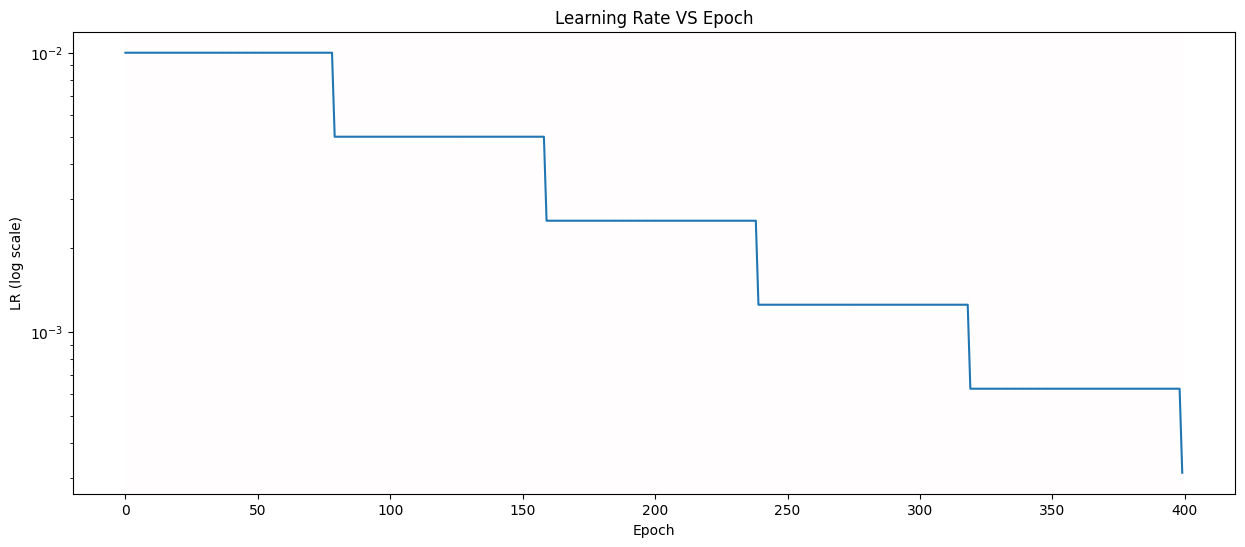

In [41]:
ax = pd.Series(lrls).plot(logy=True, figsize = (15, 6), title="Learning Rate VS Epoch")
for i in range(0,EPOCHS,1): 
    ax.axvline(i, linewidth=0.01, color='r', linestyle='--')
ax.set_xlabel("Epoch")
ax.set_ylabel("LR (log scale)")
fig = ax.get_figure()
fig.savefig('LR_graph-log.png')

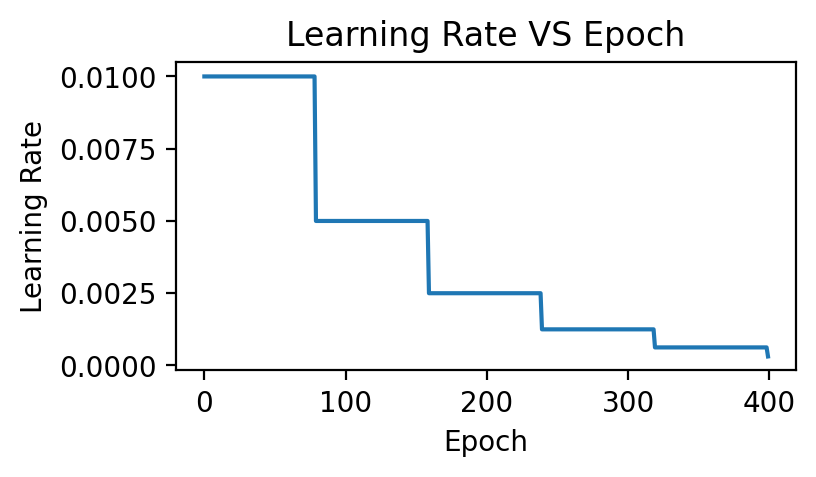

In [42]:
fig = plt.figure(figsize=(4, 2),frameon =False, dpi=200)  
plt.title('Learning Rate VS Epoch')
plt.plot(lrls)
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
fn = "LR_graph.png"
plt.savefig(fn,bbox_inches='tight')
plt.show()
plt.close()

# RESULTS

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_transforms = transform_val

In [44]:
def predict_image(image):
    
    model.eval()
    with torch.no_grad():
    
        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
       
    return index

In [45]:
def get_random_images(num):
    data = datasets.ImageFolder(VALDIR, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    images, labels = next(iter(loader))  # Get the first batch of data   
    return images, labels, classes

<Figure size 1500x1500 with 0 Axes>

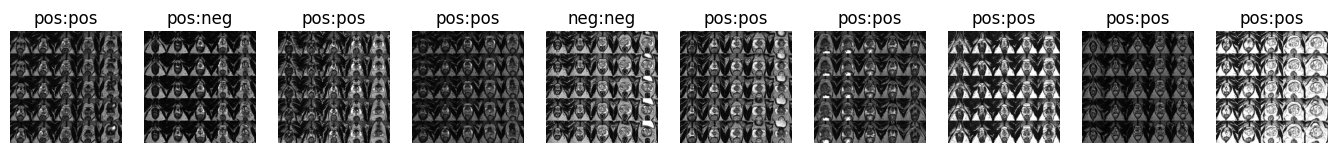

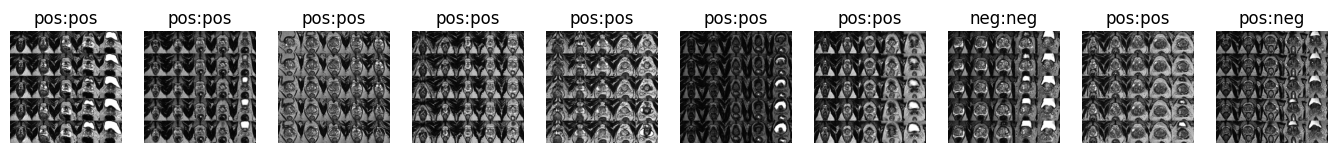

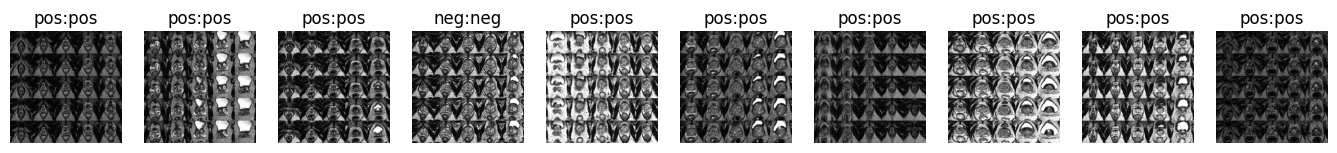

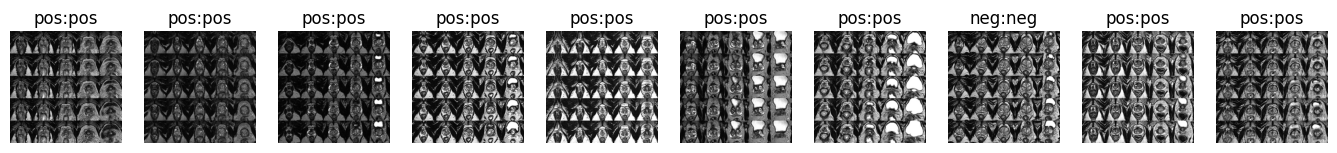

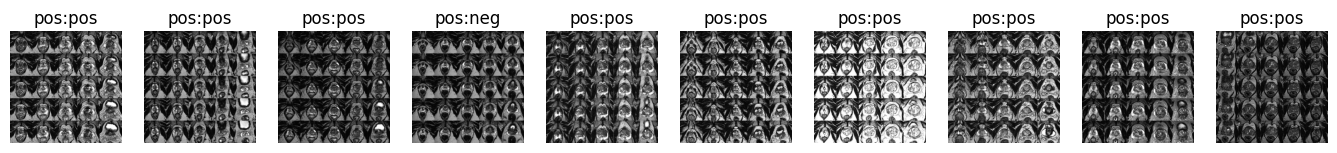

In [46]:
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(15)
fig=plt.figure(figsize=(15,15))

counter = 0
while counter < 5:
    to_pil = transforms.ToPILImage()
    images, labels, classes = get_random_images(10)
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        index = predict_image(image)
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        label_class = int(labels[ii])
        sub.set_title(str(classes[index]) + ":" + classes[label_class])
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    counter = counter + 1

## Confusion Matrix

In [47]:
actual = []
predicted = []

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(3000)
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    res = int(labels[ii])
    label_class = int(labels[ii])
    actual.append(classes[label_class])
    predicted.append(str(classes[index]))

In [48]:
print(actual[20])
print(predicted[20])

pos
pos


In [49]:
cnf_matrix = confusion_matrix(actual, predicted)

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(4, 4),frameon =False, dpi=200)  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  6  26]
 [ 14 121]]


<Figure size 640x480 with 0 Axes>

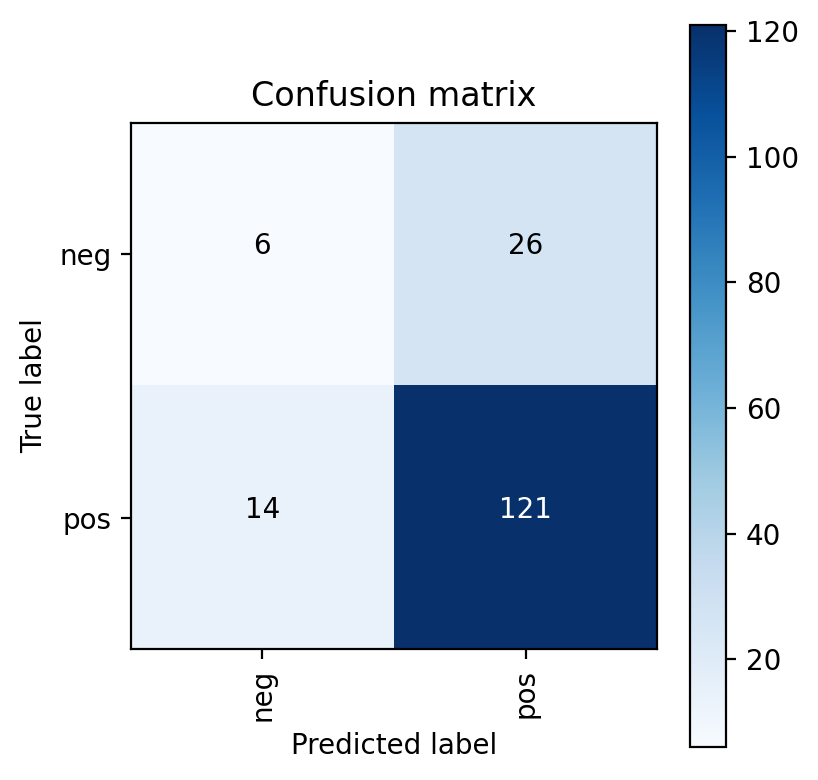

Normalized confusion matrix
[[0.1875    0.8125   ]
 [0.1037037 0.8962963]]


<Figure size 640x480 with 0 Axes>

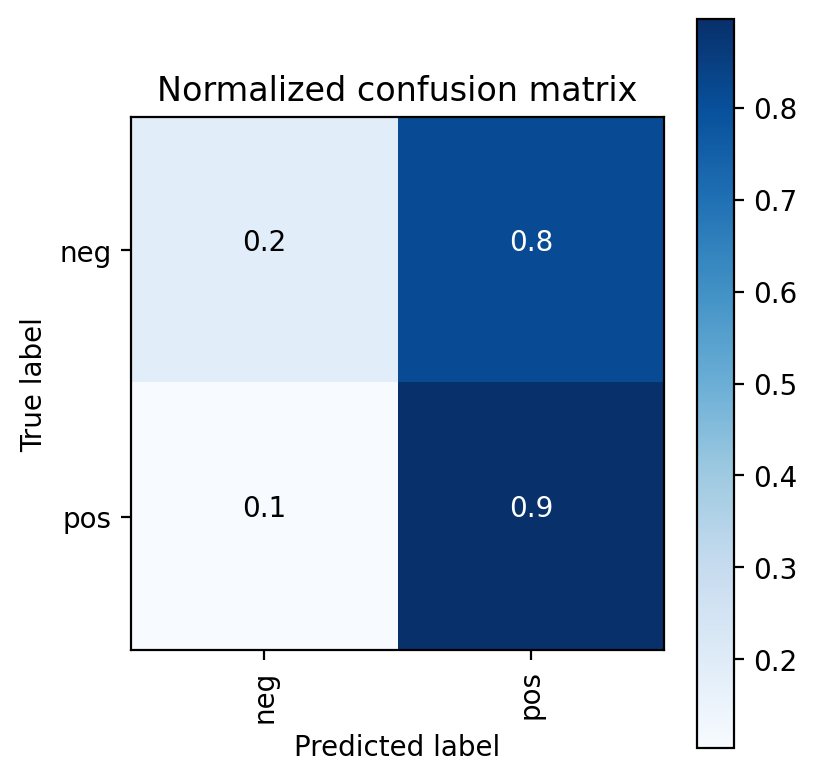

              precision    recall  f1-score   support

         neg       0.30      0.19      0.23        32
         pos       0.82      0.90      0.86       135

    accuracy                           0.76       167
   macro avg       0.56      0.54      0.54       167
weighted avg       0.72      0.76      0.74       167

0.7604790419161677


In [51]:
import itertools  # Add this line to import itertools

# Plot non-normalized confusion matrix
plt.figure()
class_names = classes
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

print(classification_report(actual, predicted, target_names=class_names))

print(accuracy_score(actual, predicted))

In [52]:
def make_ROC_graph(labels_test,prediction):
    """ Text """

    false_positive_rate, recall, thresholds = roc_curve(labels_test,prediction)
    roc_auc = auc(false_positive_rate, recall)
    fig = plt.figure(figsize=(3, 3),frameon =False, dpi=200)  
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    fn = "roc_graph.png"
    plt.savefig(fn,bbox_inches='tight')
    plt.show()
    plt.close()

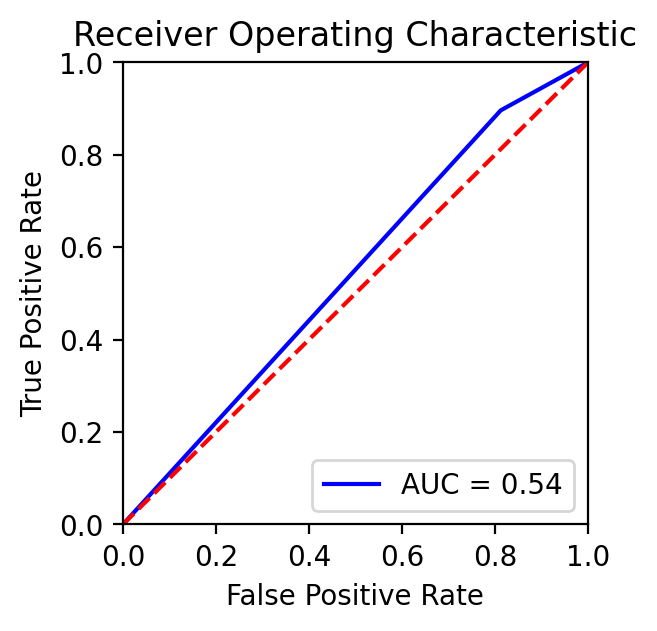

In [53]:
actual_b = []
predicted_b = []

for x in actual:
    if x == 'pos':
        actual_b.append(1)
    else:
        actual_b.append(0)

for x in predicted:
    if x == 'pos':
        predicted_b.append(1)
    else:
        predicted_b.append(0)
                
make_ROC_graph(actual_b,predicted_b)